# VLB Stress Relaxation

**Vernerey-Long-Brighenti (VLB) transient network — Stress relaxation**

## Context: VLB Relaxation Modulus

After step strain $\gamma_0$, the VLB distribution tensor $\boldsymbol{\mu}$ relaxes exponentially back to equilibrium ($\mathbf{I}$) at rate $k_d$:

$$G(t) = G_0 \, e^{-k_d t}$$

Physical picture: chains are suddenly stretched by the imposed strain, then detach (rate $k_d$) and reattach in unstressed configurations. The relaxation time $t_R = 1/k_d$ is the average bond lifetime.

**Diagnostic:** $\ln G(t)$ vs $t$ should be linear with slope $-k_d$ for single-exponential relaxation. Deviations indicate multiple bond populations (VLBMultiNetwork), permanent networks, or non-Maxwell behavior (fractional models).

> **Handbook:** See [VLB Model Reference](../../docs/source/models/vlb/vlb.rst) for relaxation spectrum, [VLB Knowledge](../../docs/source/models/vlb/vlb_knowledge.rst) for multi-mode spectrum interpretation.

## Learning Objectives

- Fit single-exponential relaxation data to extract $G_0$ and $k_d$
- Compare VLBLocal (single exponential) with VLBMultiNetwork (Prony series)
- Validate relaxation parameters against SAOS crossover

## Estimated Runtime

- ~1 min (analytical)

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import VLBLocal, VLBMultiNetwork

jax, jnp = safe_import_jax()
verify_float64()
warnings.filterwarnings("ignore", category=FutureWarning)  # JAX/equinox upstream deprecation churn — not actionable in user notebooks
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

## 2. Theory

After step strain $\gamma_0$, the relaxation modulus is:

$$G(t) = G_0 \, e^{-k_d t}$$

For multi-network (Prony series):

$$G(t) = G_e + \sum_{I=0}^{M-1} G_I \, e^{-k_{d,I} t}$$

**Diagnostic:** $\ln G(t)$ vs $t$ should be linear with slope $-k_d$.

## 3. Single-Exponential Relaxation

In [3]:
# Generate synthetic single-exponential data
np.random.seed(42)
G0_true, kd_true = 5000.0, 2.0
t_data = np.logspace(-2, 1, 40)
G_true = G0_true * np.exp(-kd_true * t_data)
G_data = G_true * (1 + 0.03 * np.random.randn(len(t_data)))

# Fit
import time

model = VLBLocal()
t0 = time.time()
model.fit(t_data, G_data, test_mode="relaxation")
t_fit = time.time() - t0

print(f"Fit time: {t_fit:.2f} s")
print(f"G₀  = {model.G0:.1f} Pa (true: {G0_true})")
print(f"k_d = {model.k_d:.4f} 1/s (true: {kd_true})")
print(f"t_R = {model.relaxation_time:.4f} s (true: {1/kd_true})")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.737715s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=14 | final_cost=0.0155 | elapsed=0.738s | final_gradient_norm=0.0200


Fit time: 0.99 s
G₀  = 4974.3 Pa (true: 5000.0)
k_d = 2.0019 1/s (true: 2.0)
t_R = 0.4995 s (true: 0.5)


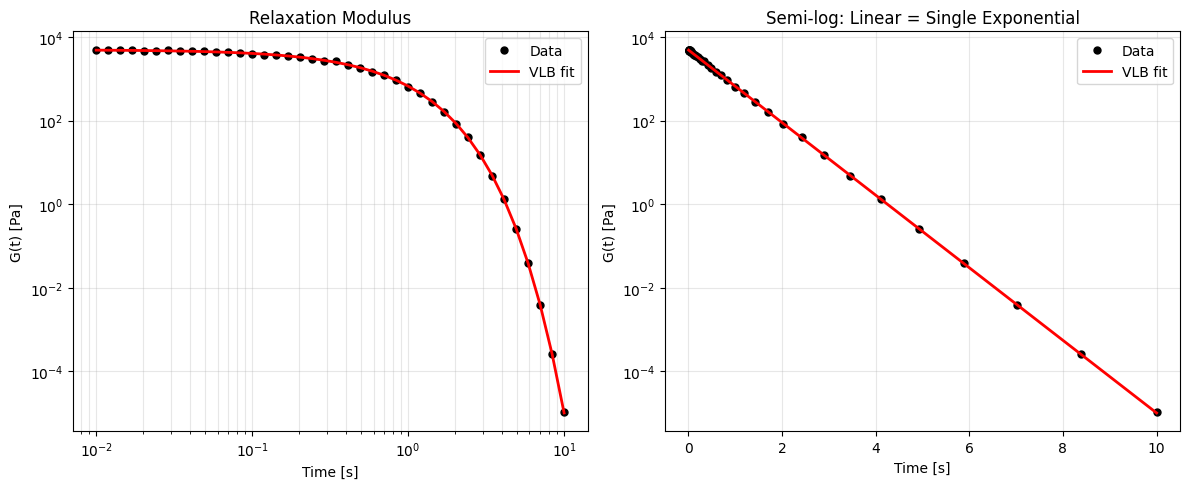

In [4]:
G_pred = model.predict(t_data, test_mode="relaxation")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Log-log
ax1.loglog(t_data, G_data, "ko", markersize=5, label="Data")
ax1.loglog(t_data, np.array(G_pred), "r-", lw=2, label="VLB fit")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("G(t) [Pa]")
ax1.set_title("Relaxation Modulus")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# Semi-log (linearity check)
ax2.semilogy(t_data, G_data, "ko", markersize=5, label="Data")
ax2.semilogy(t_data, np.array(G_pred), "r-", lw=2, label="VLB fit")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("G(t) [Pa]")
ax2.set_title("Semi-log: Linear = Single Exponential")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. Multi-Exponential Relaxation (Prony Series)

For materials with a broad relaxation spectrum, use VLBMultiNetwork.

In [5]:
# Generate 2-mode data
np.random.seed(42)
G1, kd1 = 3000.0, 0.5   # Slow mode
G2, kd2 = 2000.0, 10.0  # Fast mode
t_multi = np.logspace(-2, 2, 50)
G_multi_true = G1 * np.exp(-kd1 * t_multi) + G2 * np.exp(-kd2 * t_multi)
G_multi_data = G_multi_true * (1 + 0.03 * np.random.randn(len(t_multi)))

# Fit with VLBMultiNetwork
model_multi = VLBMultiNetwork(n_modes=2)
model_multi.fit(t_multi, G_multi_data, test_mode="relaxation")

print("Fitted relaxation spectrum:")
spectrum = model_multi.get_relaxation_spectrum()
for i, (Gi, tRi) in enumerate(spectrum):
    print(f"  Mode {i}: G = {Gi:.0f} Pa, t_R = {tRi:.4f} s (k_d = {1/tRi:.2f} 1/s)")

print(f"\nTrue: G₁={G1} Pa, k_d₁={kd1}, G₂={G2} Pa, k_d₂={kd2}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=5 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.111124s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=15 | final_cost=0.0141 | elapsed=1.111s | final_gradient_norm=1.2214e-04


Fitted relaxation spectrum:
  Mode 0: G = 2978 Pa, t_R = 1.9990 s (k_d = 0.50 1/s)
  Mode 1: G = 2176 Pa, t_R = 0.0864 s (k_d = 11.57 1/s)

True: G₁=3000.0 Pa, k_d₁=0.5, G₂=2000.0 Pa, k_d₂=10.0


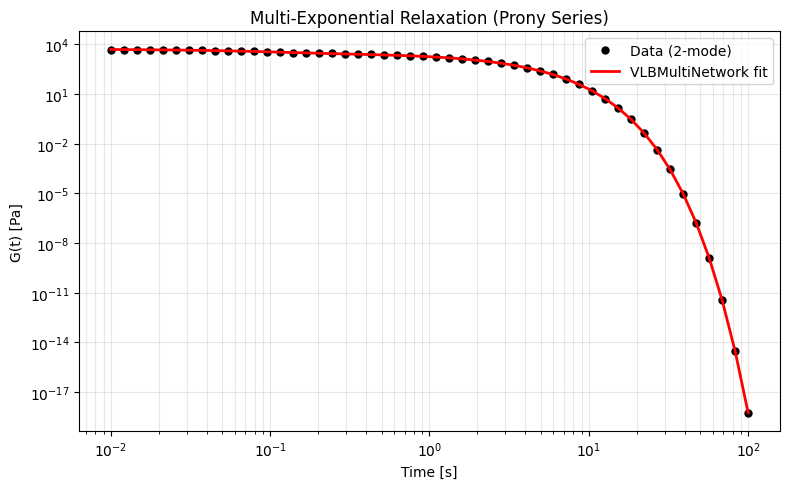

In [6]:
G_multi_pred = model_multi.predict(t_multi, test_mode="relaxation")

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(t_multi, G_multi_data, "ko", markersize=5, label="Data (2-mode)")
ax.loglog(t_multi, np.array(G_multi_pred), "r-", lw=2, label="VLBMultiNetwork fit")
ax.set_xlabel("Time [s]")
ax.set_ylabel("G(t) [Pa]")
ax.set_title("Multi-Exponential Relaxation (Prony Series)")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## Key Takeaways

1. **Single network: $G(t) = G_0 \cdot e^{-k_d t}$** — single exponential
2. **Multi-network: Prony series** — sum of exponentials for broad spectra
3. **Semi-log linearity** is the diagnostic for single vs multi-exponential
4. **$G(0) = G_0$** gives instantaneous modulus directly

## Further Reading

- [VLB Model Reference](../../docs/source/models/vlb/vlb.rst) — relaxation spectrum, multi-network formulation
- [VLB Knowledge Extraction](../../docs/source/models/vlb/vlb_knowledge.rst) — spectrum interpretation, mode assignment strategy
- Vernerey, F.J., Long, R. & Brighenti, R. (2017). *J. Mech. Phys. Solids*, 107, 1-20.

## Next Steps

- **Notebook 04**: Creep compliance
- **Notebook 05**: SAOS fitting (crossover validates $k_d$ from relaxation)